Todo:
- find the start and end of each csv.
- plot these for north and sotuh, showing gaps
- plot number of bombs per day
- plot number of detections
- have a top plot which is precision over time
- home a bottom plot which is detections per day (with double)


In [113]:
import os
from datetime import datetime, timedelta, date
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [114]:
# Global variables
# Base directory from environment
BASE_DIR = os.getenv("BASE_DIR")
if not BASE_DIR:
    raise ValueError("BASE_DIR must be set")

CSV_FOLDER: str = os.path.join(BASE_DIR, "bomb_fishing/data/mars_outputs")
BOMB_KEYWORDS = {"y", "Y", "yes", "bomb"} # keywords used by team to denote a bomb

### Plot time series

In [115]:

def load_data_by_recorder(csv_folder: str, recorder_prefix: str) -> pd.DataFrame:
    """Load and concatenate CSV files for a given north/south recorder prefix.

    Args:
        csv_folder: Path to the folder containing CSV files.
        recorder_prefix: Prefix of files to load (e.g., 'north' or 'south').

    Returns:
        DataFrame with parsed 'datetime' and 'bomb_detected' columns.
    """
    file_list = [
        os.path.join(csv_folder, f)
        for f in os.listdir(csv_folder)
        if f.lower().startswith(recorder_prefix.lower()) and f.lower().endswith(".csv")
    ]
    if not file_list:
        raise FileNotFoundError(f"No CSV files found for region '{recorder_prefix}'.")
    df_list = [pd.read_csv(fp) for fp in file_list]
    df = pd.concat(df_list, ignore_index=True)
    # Parse datetime from File column
    df["datetime"] = (
        df["File"].str.replace(".WAV", "", regex=False)
        .apply(lambda x: datetime.strptime(x, "%Y%m%d_%H%M%S"))
    )
    # Flag bomb detections
    df["bomb_detected"] = (
        df["Bombs"].astype(str).str.lower().isin(BOMB_KEYWORDS)
    )
    return df


def aggregate_daily_counts(df: pd.DataFrame) -> (pd.Series, pd.Series):
    """Aggregate bomb detections and recording presence by day.

    Args:
        df: DataFrame with 'datetime' and 'bomb_detected'.

    Returns:
        Tuple of two Series indexed by date:
          - bombs_per_day: count of detections per day.
          - recordings_per_day: count of recordings per day.
    """
    df["date"] = df["datetime"].dt.date
    all_dates = pd.date_range(start=df["date"].min(), end=df["date"].max(), freq="D")
    bombs_count = df.loc[df["bomb_detected"]].groupby("date").size()
    recordings_count = df.groupby("date").size()
    bombs_count = bombs_count.reindex(all_dates.date, fill_value=0)
    recordings_count = recordings_count.reindex(all_dates.date, fill_value=0)
    bombs_count.index = pd.to_datetime(bombs_count.index)
    recordings_count.index = pd.to_datetime(recordings_count.index)
    return bombs_count, recordings_count


def find_gap_spans(recordings_count: pd.Series) -> list[tuple[date, date]]:
    """Identify contiguous spans of days with no recordings.

    Args:
        recordings_count: Series indexed by datetime, values are counts per day.

    Returns:
        List of (start_date, end_date) tuples for each gap.
    """
    gap_days = [d.date() for d, c in recordings_count.items() if c == 0]
    if not gap_days:
        return []
    gap_days_sorted = sorted(gap_days)
    spans = []
    start = prev = gap_days_sorted[0]
    for current in gap_days_sorted[1:]:
        if current == prev + timedelta(days=1):
            prev = current
        else:
            spans.append((start, prev))
            start = prev = current
    spans.append((start, prev))
    return spans

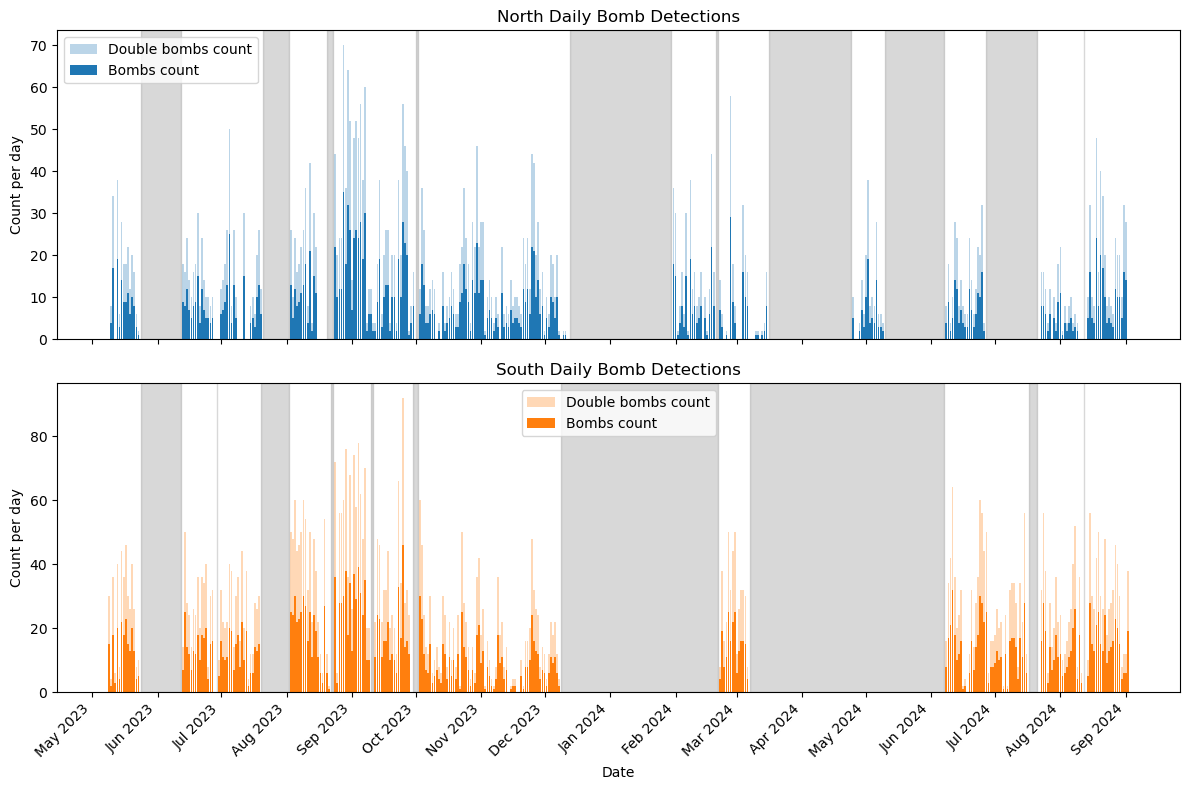

In [116]:
def plot_bomb_time_series(csv_folder: str) -> None:
    """Plot daily bomb counts with recording gaps shaded *between* bars."""
    recorders = ["north", "south"]
    fig, axes = plt.subplots(len(recorders), 1, sharex=True, figsize=(12, 8))
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    bar_width = 0.8                           # days
    half_width = bar_width / 2

    for ax, recorder, color in zip(axes, recorders, colors):
        df = load_data_by_recorder(csv_folder, recorder)
        bombs_count, recordings_count = aggregate_daily_counts(df)
        gap_spans = find_gap_spans(recordings_count)
        dates = bombs_count.index

        # Shade gaps *between* bars, inset by half_width days on each side:
        for start, end in gap_spans:
            ax.axvspan(
                start + timedelta(days=half_width),
                end + timedelta(days=1 - half_width),
                color="grey",
                alpha=0.3,
                zorder=0,
            )

        # Plot the double‐height “background” bars
        ax.bar(
            dates,
            bombs_count * 2,
            width=bar_width,
            color=color,
            alpha=0.3,
            label="Double bombs count",
            zorder=1,
        )
        # Plot the real counts on top
        ax.bar(
            dates,
            bombs_count,
            width=bar_width,
            color=color,
            label="Bombs count",
            zorder=2,
        )

        ax.set_title(f"{recorder.capitalize()} Daily Bomb Detections")
        ax.set_ylabel("Count per day")
        ax.legend()

    # Tidy up dates
    axes[-1].xaxis.set_major_locator(mdates.MonthLocator())
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    fig.autofmt_xdate(rotation=45)
    plt.xlabel("Date")
    fig.tight_layout()
    plt.show()

plot_bomb_time_series(CSV_FOLDER)

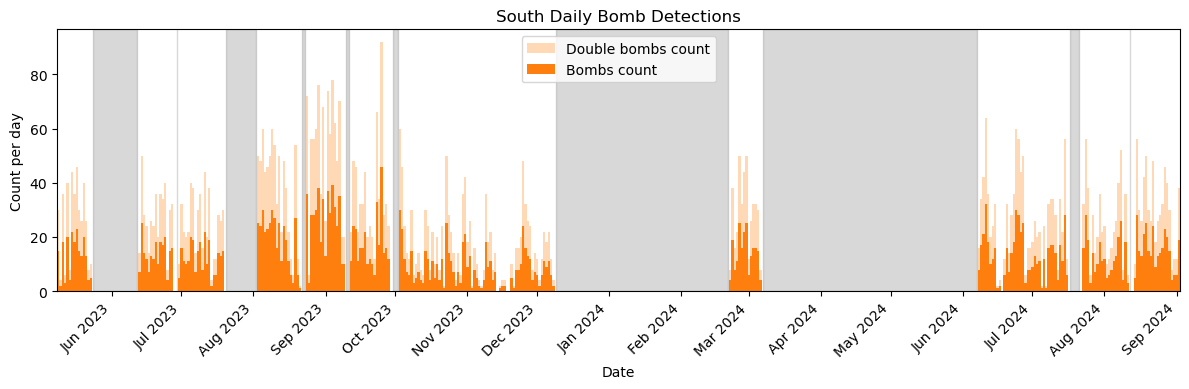

In [117]:
# South-only daily bomb detections


# Parameters
recorder = "south"
bar_width = 1                    # in days
half_width = bar_width / 2
colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]
colour = colours[1] # gets that nice contrasting ornage colour

# Load & aggregate
df          = load_data_by_recorder(CSV_FOLDER, recorder)
bombs_count, recordings_count = aggregate_daily_counts(df)
gaps        = find_gap_spans(pd.Series(recordings_count.values, index=bombs_count.index))

# Plot setup
fig, ax = plt.subplots(figsize=(12, 4))

# Shade gaps *between* bars
for start, end in gaps:
    ax.axvspan(
        start + timedelta(days=half_width),
        end   + timedelta(days=1 - half_width),
        color="grey",   # use 'color', not 'colour'
        alpha=0.3,
        zorder=0,
    )

# Double-height “background” bars
ax.bar(
    bombs_count.index,
    bombs_count.values * 2,
    width=bar_width,
    color=colour,    # use 'color'
    alpha=0.3,
    label="Double bombs count",
    zorder=1,
)

# Actual bomb counts
ax.bar(
    bombs_count.index,
    bombs_count.values,
    width=bar_width,
    color=colour,    # use 'color'
    label="Bombs count",
    zorder=2,
)

# Formatting
ax.margins(x=0) # remove extra white space on left/right

ax.set_title("South Daily Bomb Detections")
ax.set_ylabel("Count per day")
ax.legend()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
fig.autofmt_xdate(rotation=45)
plt.xlabel("Date")
plt.tight_layout()
plt.show()


### Print recording len and bomb count
This is total time that ahs passed between the start of deployment and end. So later we cut in half to get the true recording time due to 1 in 2 min duty cycle.

In [118]:
def get_recording_periods(csv_folder: str, recorder_prefix: str) -> pd.DataFrame:
    """Compute start and end datetimes for each CSV (continuous recording period).

    Args:
        csv_folder: Path to CSV folder.
        recorder_prefix: 'north' or 'south'.

    Returns:
        DataFrame with columns ['file', 'start', 'end', 'duration'].
    """
    records = []
    for fname in os.listdir(csv_folder):
        if not fname.lower().startswith(recorder_prefix.lower()) or not fname.lower().endswith('.csv'):
            continue
        path = os.path.join(csv_folder, fname)
        tmp = pd.read_csv(path)
        # parse first and last datetime
        times = (
            tmp['File'].str.replace('.WAV', '', regex=False)
            .apply(lambda x: datetime.strptime(x, '%Y%m%d_%H%M%S'))
        )
        start, end = times.min(), times.max()
        duration = end - start
        records.append({'file': fname, 'start': start, 'end': end, 'duration': duration})
    return pd.DataFrame(records)


def print_summary(csv_folder: str) -> None:
    """Print bomb totals and bombs-per-recording-day rate for each site."""
    for site in ['north', 'south']:
        # Load data and periods
        df = load_data_by_recorder(csv_folder, site)
        periods = get_recording_periods(csv_folder, site)

        # Total bombs
        raw = int(df['bomb_detected'].sum())
        doubled = raw * 2

        # Overall span
        start = periods['start'].min().date()
        end   = periods['end'].max().date()
        days_total = (end - start).days + 1

        # Total audio duration adjusted for duty cycle
        total_dur = periods['duration'].sum() / 2  # a timedelta
        days_rec  = total_dur.total_seconds() / (3600 * 24)  # float days

        # Simple rate: bombs per recording-day
        bombs_per_rec_day = raw / days_rec if days_rec > 0 else float('nan')

        # Print summary
        print(f"{site.capitalize()} site:")
        print(f"  Period: {start} → {end} ({days_total} days inclusive)")
        print(f"  Bombs detected: {raw} (×2 → {doubled})")
        print(f"  Recording-days (adjusted): {days_rec:.2f}")
        print(f"  Bombs per recording-day: {bombs_per_rec_day:.2f}\n")


print_summary(CSV_FOLDER)

North site:
  Period: 2023-05-10 → 2024-09-01 (481 days inclusive)
  Bombs detected: 2296 (×2 → 4592)
  Recording-days (adjusted): 169.54
  Bombs per recording-day: 13.54

South site:
  Period: 2023-05-09 → 2024-09-02 (483 days inclusive)
  Bombs detected: 3567 (×2 → 7134)
  Recording-days (adjusted): 154.12
  Bombs per recording-day: 23.14

